In [10]:
include("ArbitraryHamiltonian.jl")
using OpenQuantumTools
using QuantumInformation
using DifferentialEquations
using OrdinaryDiffEq
using LinearAlgebra
using Plots
#using LsqFit
using DM
using HDF5

In [4]:
### Create the subsystems ###

# dissipator Transmon
diss = Transmon(ω01 = 9.5 * 2 * pi +0.0*im, α = 0.3 * 2 * pi, γ = 0.030 * 2 * pi, N = 4)
# logical Qubit
logic = Qubit(ω01 = 3.5 * 2 * pi +0.0*im)
# high Q Resonator mode
high = Resonator(ω01 = 5.95 * 2 * pi +0.0*im, κ = 0.001 * 2 * pi, N = 3)
# low Q Resonator mode
#low = Resonator(ω01 = 7.37 * 2 * pi +0.0*im, κ = 0.005 * 2 * pi, N = 3)

### Write operators in full system basis ###

# energy operators written in combined basis
#energy_all = FullDim_energy(diss,logic,high,low)
energy_all = FullDim_energy(diss,logic,high)
E_diss = energy_all[1]
E_logic = energy_all[2]
E_high = energy_all[3]
#E_low = energy_all[4]

# anhilation operators written in combined basis
#a_all = FullDim_a(diss,logic,high,low)
a_all = FullDim_a(diss,logic,high)
a_diss = a_all[1]
a_logic = a_all[2]
a_high = a_all[3]
#a_low = a_all[4]

# creation operators written in combined basis
#adag_all = FullDim_a(diss,logic,high,low)
adag_all = FullDim_adag(diss,logic,high)
adag_diss = adag_all[1]
adag_logic = adag_all[2]
adag_high = adag_all[3]
#adag_low = adag_all[4]

# interaction operators 
g_diss_high = 0.25*2*pi
#g_diss_low = 0.25*2*pi
g_logic_high = 0.20*2*pi
couple_diss_high = g_diss_high*(a_high+adag_high)*(a_diss+adag_diss)
#couple_diss_low = g_diss_low*(a_low+adag_low)*(a_diss+adag_diss)
couple_logic_high = g_logic_high*(a_high+adag_high)*(a_logic+adag_logic)

### define initial state of combined system ###

# relevant initial states
state_diss = 1              # 1 = g, 2 = e, 3 = f, ... 
state_qubit = [1,1]         # [(1/2/3 = x/y/z), (1/2 = excited/ground)]
state_high = 2              # (n - 1) photons
#state_low = 1               # (n - 1) photons
state_vec_diss = diss.basis[:,state_diss]
state_vec_qubit = PauliVec[state_qubit[1]][state_qubit[2]] # may re-write this later
state_vec_high = high.basis[:,state_high]
#state_vec_low = low.basis[:,state_low]

#state_vec_all = kron(kron(kron(state_vec_diss,state_vec_qubit),state_vec_high),state_vec_low)
state_vec_all = kron(kron(state_vec_diss,state_vec_qubit),state_vec_high)

24-element Array{Complex{Float64},1}:
                0.0 + 0.0im
 0.7071067811865475 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.7071067811865475 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [5]:
### Now, create hamiltonian operators from the matrices defined above ###

# energy operators
m1 = E_diss
m2 = E_logic
m3 = E_high
#m4 = E_low

# coupling operators
m5 = couple_diss_high
#m6 = couple_diss_low
m7 = couple_diss_high

# drive operators
δω_diss_high = 0.3*2*pi
Δ_diss_high = diss.ω01 - high.ω01 
χ_diss_high = g_diss_high^2*diss.α/(Δ_diss_high^2)
ωd_diss_high = Δ_diss_high + 25*χ_diss_high

#δω_diss_low = 0.3*2*pi
#Δ_diss_low = diss.ω01 - low.ω01 
#χ_diss_low = g_diss_low^2*diss.α/(Δ_diss_low^2)
#ωd_diss_low = Δ_diss_low + 25*χ_diss_low

m8 = adag_diss*a_diss

24×24 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [6]:
### define lindblad terms ###

linda_diss = Lindblad(diss.γ,a_diss)
linda_high = Lindblad(high.κ,a_high)
#linda_low = Lindblad(low.κ,a_low)

temperature = 75 * 0.0208 * 2 * pi 
warming_rate_high = high.κ*exp(-high.ω01/temperature)
#warming_rate_low = low.κ*exp(-low.ω01/temperature)
lindadag_high = Lindblad(warming_rate_high,adag_high)
#lindadag_low = Lindblad(warming_rate_low,adag_low)

#interactions_all = (linda_diss,linda_high,linda_low,lindadag_high,lindadag_low)
interactions_all = (linda_diss,linda_high,lindadag_high)

(Lindblad(OpenQuantumBase.var"#68#70"{Float64}(0.18849555921538758), OpenQuantumBase.var"#69#71"{Array{Float64,2}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), (24, 24)), Lindblad(OpenQuantumBase.var"#68#70"{Float64}(0.006283185307179587), OpenQuantumBase.var"#69#71"{Array{Float64,2}}([0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.4142135623730951; 0.0 0.0 … 0.0 0.0]), (24, 24)), Lindblad(OpenQuantumBase.var"#68#70"{Complex{Float64}}(0.00013859136473130487 - 0.0im), OpenQuantumBase.var"#69#71"{Array{Float64,2}}([0.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.4142135623730951 0.0]), (24, 24)))

In [11]:
### Run simulation without added drive ###
system_components = "diss.logic.high"
system_dimensions = string(string(diss.N),".",string(logic.N),".",string(high.N))

time_final = 100
H0 = DenseHamiltonian([s->1,s->1,s->1,s->1,s->1],[m1,m2,m3,m5,m7],unit=:ħ)
anneal0 = Annealing(H0,state_vec_all,interactions = InteractionSet(interactions_all))
sol0 = solve_lindblad(anneal0,time_final,abstol=1e-6,reltol=1e-6)

# save this run
activate_param_set("params.json")
d, = load_config_from_json("test.json")
entry = d["Linblad"]
val = Dict("eta"=>1e-6,"tf"=> 100)
# save solutions in distinct files
res_u0 = VectorOfArray(sol0.u)
arr_u0 = convert(Array,res_u0)
res_t0 = VectorOfArray(sol0.t)
arr_t0 = convert(Array,res_t0)
file_name0 = string(system_components,".",system_dimensions,".NoDrive.h5")
save(entry, val, file_name0, "rho", arr_u0)
save(entry, val, file_name0, "time", arr_t0)

In [12]:
### Run simulation with added drive ###
system_components = "diss.logic.high"
system_dimensions = string(string(diss.N),".",string(logic.N),".",string(high.N))

time_final = 100
H = DenseHamiltonian([s->1,s->1,s->1,s->1,s->1,s->(δω_diss_high*cos(ωd_diss_high*s*time_final))],[m1,m2,m3,m5,m7,m8],unit=:ħ)
anneal = Annealing(H,state_vec_all,interactions = InteractionSet(interactions_all))
sol = solve_lindblad(anneal,time_final,abstol=1e-6,reltol=1e-6)

# save this run
activate_param_set("params.json")
d, = load_config_from_json("test.json")
entry = d["Linblad"]
val = Dict("eta"=>1e-6,"tf"=> 100)
# save solutions in distinct files
res_u = VectorOfArray(sol.u)
arr_u = convert(Array,res_u)
res_t = VectorOfArray(sol.t)
arr_t = convert(Array,res_t)
file_name = string(system_components,".",system_dimensions,".WithDrive.h5")
save(entry, val, file_name, "rho", arr_u)
save(entry, val, file_name, "time", arr_t)

In [14]:
load_rho0 = load(entry, val, string(system_components,".",system_dimensions,".NoDrive.h5"), "rho")
load_rho = load(entry, val, string(system_components,".",system_dimensions,".WithDrive.h5"), "rho")

load_time0 = load(entry, val, string(system_components,".",system_dimensions,".NoDrive.h5"), "time")
load_time = load(entry, val, string(system_components,".",system_dimensions,".WithDrive.h5"), "time")

7392-element Array{Float64,1}:
   0.0
   0.011301039720560832
   0.017688512202088325
   0.02681600404463149
   0.034590139563777114
   0.043324791168988255
   0.05171100150653522
   0.060457380321210515
   0.0691467168531113
   0.07799485309771806
   0.08687813560858071
   0.09585492335256406
   0.10488406657257861
   ⋮
  99.83760944565846
  99.85337019892584
  99.86915737872606
  99.88496333097365
  99.90079542844656
  99.91668663624587
  99.93265065339638
  99.94866681646504
  99.96470535393642
  99.98074528661
  99.9967633611994
 100.0

In [31]:
idims = [diss.N,logic.N,high.N]
sys_traced = [1,3]

load_time_array0 = []
load_time_array = []
purity_qubit0 = []
purity_qubit = []

for j in range(1,length(load_time0),step=200) ###
    newarray0=load_rho0[:, :, j]
    newarrayt0=load_time[j]
    push!(purity_qubit0,real(tr((ptrace(newarray0,idims,sys_traced)^2))))
    push!(load_time_array0,newarrayt0)
end
for j in range(1,length(load_time),step=200)
    newarray=load_rho[:,:,j]
    newarrayt=load_time[j]
    push!(purity_qubit,real(tr((ptrace(newarray,idims,sys_traced)^2))))
    push!(load_time_array,newarrayt)
end

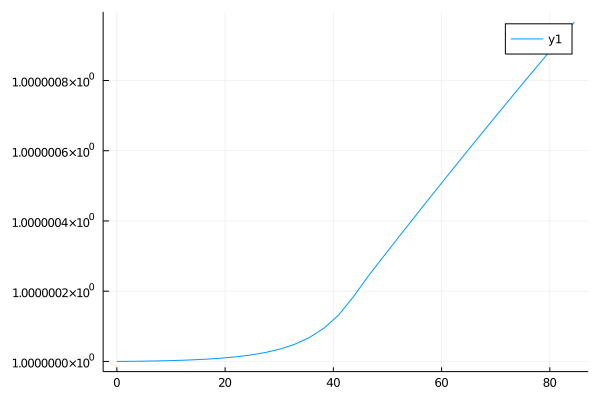

In [32]:
time_list = range(0,time_final,length=200)

Plots.plot(load_time_array0,purity_qubit0)

In [21]:
length(load_time)

7392

In [22]:
length(load_rho)

4257792

In [23]:
length(load_rho0)

3738816

In [24]:
length(load_time0)

6491